In [3]:
import pandas as pd
import numpy as np

df_90["date"] = pd.to_datetime(df_90["date"]).dt.normalize()
arima  = pd.read_csv("../90 days/predictions/arima_predictions_90.csv")
sarima = pd.read_csv("../90 days/predictions/sarima_predictions_90.csv")
rf     = pd.read_csv("../90 days/predictions/rf_predictions_90.csv")
gb     = pd.read_csv("../90 days/predictions/gb_predictions_90.csv")


NameError: name 'df_90' is not defined

In [4]:
# Normalize dates in all prediction tables
for d in [arima, sarima, rf, gb]:
    d["date"] = pd.to_datetime(d["date"]).dt.normalize()

NameError: name 'arima' is not defined

In [5]:
arima = arima[["date", "arima_pred"]].rename(columns={"arima_pred": "pred_arima"})

NameError: name 'arima' is not defined

In [6]:
sarima_pred_col = None
for c in sarima.columns:
    if c.lower() in ["sarima", "sarima_pred"]:
        sarima_pred_col = c
        break
if sarima_pred_col is None:
    raise ValueError(f"Can't find SARIMA prediction column in: {sarima.columns.tolist()}")

sarima = sarima[["date", sarima_pred_col]].rename(columns={sarima_pred_col: "pred_sarima"})

NameError: name 'sarima' is not defined

In [7]:
rf = rf[["date", "rf_1", "rf_2", "rf_3", "rf_4", "rf_5"]].rename(columns={
    "rf_1":"pred_rf_1", "rf_2":"pred_rf_2", "rf_3":"pred_rf_3", "rf_4":"pred_rf_4", "rf_5":"pred_rf_5"
})

NameError: name 'rf' is not defined

In [65]:
gb = gb[["date", "gb_1", "gb_2", "gb_3", "gb_4", "gb_5"]].rename(columns={
    "gb_1":"pred_gb_1", "gb_2":"pred_gb_2", "gb_3":"pred_gb_3", "gb_4":"pred_gb_4", "gb_5":"pred_gb_5"
})

In [66]:
df_90 = df_90.drop(columns=[c for c in df_90.columns if c.startswith("pred_")], errors="ignore")

df_90 = df_90.merge(arima,  on="date", how="left", validate="one_to_one")
df_90 = df_90.merge(sarima, on="date", how="left", validate="one_to_one")
df_90 = df_90.merge(rf,     on="date", how="left", validate="one_to_one")
df_90 = df_90.merge(gb,     on="date", how="left", validate="one_to_one")

In [67]:
pred_cols = ["pred_arima", "pred_sarima",
             "pred_rf_1","pred_rf_2","pred_rf_3","pred_rf_4","pred_rf_5",
             "pred_gb_1","pred_gb_2","pred_gb_3","pred_gb_4","pred_gb_5"]

missing = df_90[pred_cols].isna().sum()
print("Missing counts (only show >0):\n", missing[missing > 0])
assert missing.sum() == 0, "Some predictions didn't match dates!"

print("✅ Merge done. df_90 columns now include predictions.")
print(df_90.columns.tolist())

Missing counts (only show >0):
 Series([], dtype: int64)
✅ Merge done. df_90 columns now include predictions.
['date', 'actual', 'arima', 'sarima_pred_x', 'rf_1', 'rf_2', 'rf_3', 'rf_4', 'rf_5', 'gb_1', 'gb_2', 'gb_3', 'gb_4', 'gb_5', 'sarima_pred_y', 'pred_arima', 'pred_sarima', 'pred_rf_1', 'pred_rf_2', 'pred_rf_3', 'pred_rf_4', 'pred_rf_5', 'pred_gb_1', 'pred_gb_2', 'pred_gb_3', 'pred_gb_4', 'pred_gb_5']


In [68]:
rf_cols = ["pred_rf_1","pred_rf_2","pred_rf_3","pred_rf_4","pred_rf_5"]
gb_cols = ["pred_gb_1","pred_gb_2","pred_gb_3","pred_gb_4","pred_gb_5"]

df_90["rf_mean"] = df_90[rf_cols].mean(axis=1)
df_90["rf_std"]  = df_90[rf_cols].std(axis=1)

df_90["gb_mean"] = df_90[gb_cols].mean(axis=1)
df_90["gb_std"]  = df_90[gb_cols].std(axis=1)

X_meta = df_90[["pred_arima", "pred_sarima", "rf_mean", "rf_std", "gb_mean", "gb_std"]]
y_meta = df_90["actual"].to_numpy()

In [69]:
import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 100, log=True)

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=alpha))
    ])

    tscv = TimeSeriesSplit(n_splits=5)
    rmses = []

    for train_idx, val_idx in tscv.split(X_meta):
        X_train, X_val = X_meta.iloc[train_idx], X_meta.iloc[val_idx]
        y_train, y_val = y_meta[train_idx], y_meta[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))

    return np.mean(rmses)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_alpha = study.best_params["alpha"]
print("Best Ridge alpha:", best_alpha)

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("\nRMSE comparisons on last 90 days:")
print("ARIMA   :", rmse(y_meta, df_90["pred_arima"]))
print("SARIMA  :", rmse(y_meta, df_90["pred_sarima"]))
print("RF_mean :", rmse(y_meta, df_90["rf_mean"]))
print("GB_mean :", rmse(y_meta, df_90["gb_mean"]))
print("STACK   :", rmse(y_meta, df_90["stack"]))

print("\nMAE STACK:", mean_absolute_error(y_meta, df_90["stack"]))


RMSE comparisons on last 90 days:
ARIMA   : 6.173835779713577
SARIMA  : 6.177274942527559
RF_mean : 6.323231377425493
GB_mean : 6.216708544565793
STACK   : 6.0846614386034

MAE STACK: 4.6371597411941545


In [75]:
y_true = y_meta
y_pred = df_90["stack"].to_numpy()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-8  # avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

RMSE = rmse(y_true, y_pred)
MAE  = mean_absolute_error(y_true, y_pred)
MAPE = mape(y_true, y_pred)
ACC  = 100 - MAPE  # "accuracy" in your definition

print(f"STACK RMSE      : {RMSE:.4f}")
print(f"STACK MAE       : {MAE:.4f}")
print(f"STACK MAPE (%)  : {MAPE:.4f}")
print(f"STACK Accuracy% : {ACC:.4f}")

STACK RMSE      : 6.0847
STACK MAE       : 4.6372
STACK MAPE (%)  : 16.5008
STACK Accuracy% : 83.4992


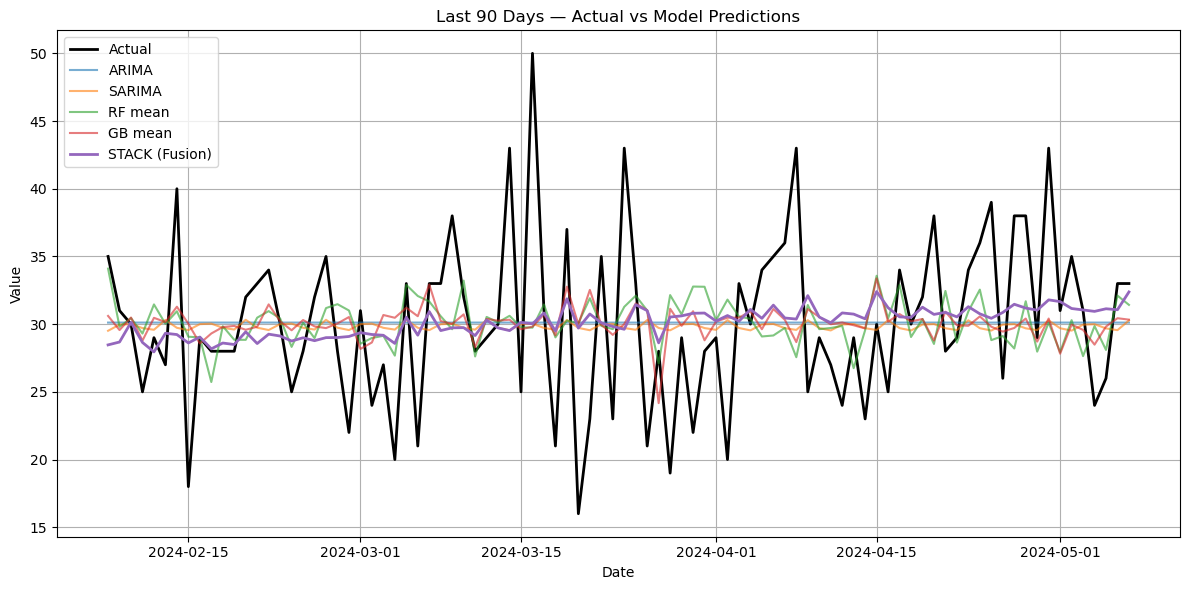

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df_90["date"], y_meta, label="Actual", linewidth=2, color="black")
plt.plot(df_90["date"], df_90["pred_arima"], label="ARIMA", alpha=0.6)
plt.plot(df_90["date"], df_90["pred_sarima"], label="SARIMA", alpha=0.6)
plt.plot(df_90["date"], df_90["rf_mean"], label="RF mean", alpha=0.6)
plt.plot(df_90["date"], df_90["gb_mean"], label="GB mean", alpha=0.6)
plt.plot(df_90["date"], df_90["stack"], label="STACK (Fusion)", linewidth=2)

plt.title("Last 90 Days — Actual vs Model Predictions")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()